### Setup environment

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten 
from tensorflow.keras.datasets import mnist
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
import sklearn
from sklearn.metrics import roc_auc_score 
import mlflow
import mlflow.tensorflow

2025-09-02 15:30:30.550366: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 15:30:30.556945: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-02 15:30:30.614250: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-02 15:30:30.681230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-02 15:30:30.745114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:

print("TensorFlow: {}".format(tf.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("Numpy: {}".format(np.__version__))
print("MLFlow: {}".format(mlflow.__version__))
print("Matplotlib: {}".format(matplotlib.__version__))

TensorFlow: 2.17.0
Scikit-Learn: 1.7.1
Numpy: 1.26.4
MLFlow: 3.3.2
Matplotlib: 3.10.6


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Class:  5


(<matplotlib.image.AxesImage at 0x7a5026f32c00>, None)

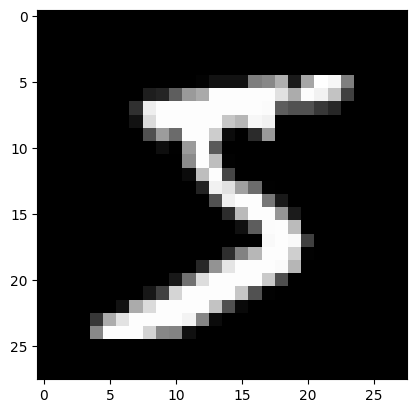

In [4]:
plt.imshow(x_train[0], cmap='gray'), print("Class: ", y_train[0])

In [5]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],
x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],
x_test.shape[2], 1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [6]:
print("Shapes")
print("x_train: {}\ny_train: {}".format(x_train.shape,y_train.shape))
print("x_test: {}\ny_test: {}".format(x_test.shape,y_test.shape))

Shapes
x_train: (60000, 28, 28, 1)
y_train: (60000, 10)
x_test: (10000, 28, 28, 1)
y_test: (10000, 10)


### MLFlow Run - Training and Evaluation

In [7]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, strides=2,padding='same', input_shape=(28, 28, 1), activation="relu"))
model.add(Conv2D(filters=8, kernel_size=3, strides=2,padding='same', input_shape=(28, 28, 1), activation="relu"))
model.add(Flatten())
model.add(Dense(30, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.summary()

/home/leoncariou/code/cours/MLflow-Workshop/mlflow_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        11,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,940 (54.45 KB)

 Trainable params: 13,940 (54.45 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer="Adam",loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
mlflow.set_tracking_uri('http://localhost:8080')
mlflow.set_experiment("TF_Keras_MNIST") 

<Experiment: artifact_location='mlflow-artifacts:/506146471734835318', creation_time=1756820087843, experiment_id='506146471734835318', last_update_time=1756820087843, lifecycle_stage='active', name='TF_Keras_MNIST', tags={}>

In [12]:
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    model.fit(x=x_train, y=y_train, batch_size=256, epochs=10)
    preds = model.predict(x_test)
    preds = np.round(preds)
    eval_acc = model.evaluate(x_test, y_test)[1]
    auc_score = roc_auc_score(y_test, preds)
    print("eval_acc: ", eval_acc)
    print("auc_score: ", auc_score)
    mlflow.tensorflow.mlflow.log_metric("eval_acc", eval_acc)
    mlflow.tensorflow.mlflow.log_metric("auc_score", auc_score)
mlflow.end_run()

Epoch 1/10
228/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4325 - loss: 3.6226

2025/09/02 15:34:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6247 - loss: 1.6088
Epoch 2/10
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8994 - loss: 0.3554

2025/09/02 15:34:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9129 - loss: 0.3053
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9421 - loss: 0.1990

2025/09/02 15:34:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9462 - loss: 0.1843
Epoch 4/10
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9583 - loss: 0.1405

2025/09/02 15:35:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9594 - loss: 0.1377
Epoch 5/10
229/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9638 - loss: 0.1156

2025/09/02 15:35:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9660 - loss: 0.1127
Epoch 6/10
225/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9720 - loss: 0.0930

2025/09/02 15:35:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9722 - loss: 0.0925
Epoch 7/10
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9755 - loss: 0.0805

2025/09/02 15:35:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9756 - loss: 0.0810
Epoch 8/10
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9799 - loss: 0.0684

2025/09/02 15:35:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9788 - loss: 0.0707
Epoch 9/10
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9822 - loss: 0.0593

2025/09/02 15:35:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9810 - loss: 0.0625
Epoch 10/10
229/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9827 - loss: 0.0534

2025/09/02 15:35:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9824 - loss: 0.0559


2025/09/02 15:35:07 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2025/09/02 15:35:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/02 15:35:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/09/02 15:35:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9757 - loss: 0.0869
eval_acc:  0.9757000207901001
auc_score:  0.9859531726331447
🏃 View run secretive-skunk-142 at: http://localhost:8080/#/experiments/506146471734835318/runs/4685222ce5604771866081f893ac56e9
🧪 View experiment at: http://localhost:8080/#/experiments/506146471734835318


### Evaluate the Model

In [14]:
eval_loss, eval_acc = model.evaluate(x_test, y_test)
preds = model.predict(x_test)
preds = np.round(preds)
eval_auc = roc_auc_score(y_test, preds)
print("Eval Loss:", eval_loss)
print("Eval Acc:", eval_acc)
print("Eval AUC:", eval_auc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9757 - loss: 0.0869
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
Eval Loss: 0.08689630031585693
Eval Acc: 0.9757000207901001
Eval AUC: 0.9859531726331447
